<div dir="rtl">
    <font size="5"><b>پروژه پنجم (فاز اول) – پیاده سازی و آموزش شبکه های عصبی Feed Forward</b><br></font>
    <font size="3">هدف پروژه: در فاز اول پروژه پنجم به پیاده سازی شبکه های عصبی چند لایه  جهت طبقه بندی تصاویر می پردازیم.<br>
        مجموعه داده: در این پروژه با یک مجموعه داده KMnist شامل تصاویری در مقیاس 28 در 28 پیکسل بصورت grayscale و 75000 تصویر از 20 کلاس مختلف کار خواهیم کرد.<br></font>
</div>

<div dir="rtl">
    <font size="4"><b>فاز اول: بررسی و پیش پردازش داده ها</b><br></font>
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_images = np.genfromtxt('train_images.csv', delimiter=',')
train_images = np.delete(train_images, (0), axis=0)
train_images = np.delete(train_images, (0), axis=1)
train_labels = np.genfromtxt('train_labels.csv', delimiter=',')
train_labels = np.delete(train_labels, (0), axis=0)
train_labels = np.delete(train_labels, (0), axis=1)
test_images = np.genfromtxt('test_images.csv', delimiter=',')
test_images = np.delete(test_images, (0), axis=0)
test_images = np.delete(test_images, (0), axis=1)
test_labels = np.genfromtxt('test_labels.csv', delimiter=',')
test_labels = np.delete(test_labels, (0), axis=0)
test_labels = np.delete(test_labels, (0), axis=1)

In [3]:
train_labels = train_labels.reshape((60000, 1))
test_labels = test_labels.reshape((15000, 1))

<div dir="rtl">
    <font size="3">• بررسی یک تصویر در مجموعه داده train بصورت رندوم (مقدار هر پیکسل عددی بین صفر و 255 است):</font>
</div>

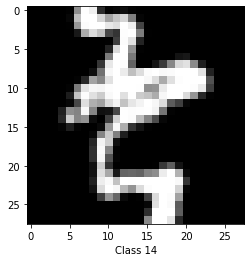

In [4]:
plt.figure()
plt.xlabel('Class ' + str(train_labels[1000][0].astype(np.uint8)))
plt.imshow(np.reshape(train_images[1000], (28, 28)), cmap='gray')

<div dir="rtl">
    <font size="3">• نمایش یک تصویر دلخواه و نوع آن از هر کلاس در مجموعه داده train</font>
</div>

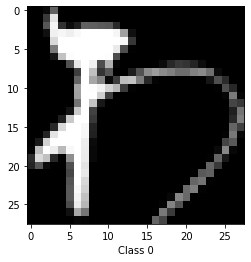

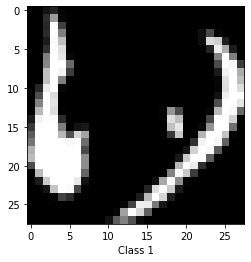

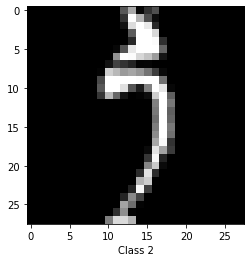

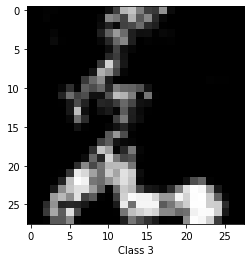

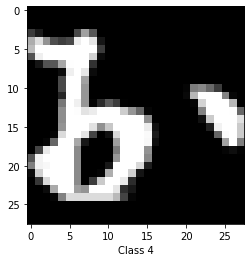

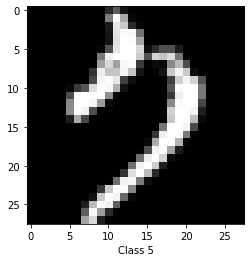

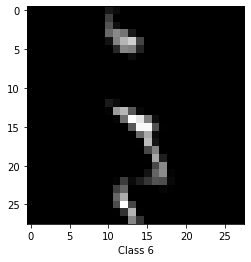

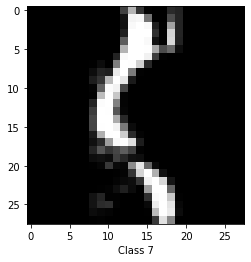

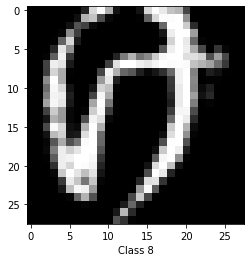

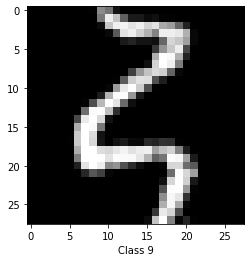

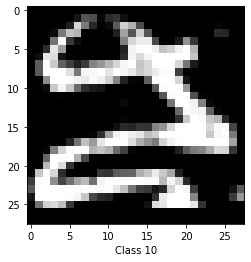

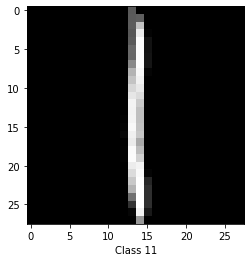

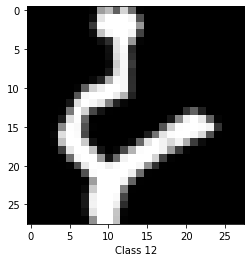

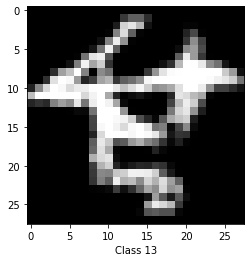

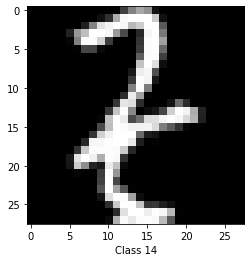

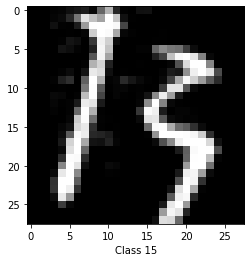

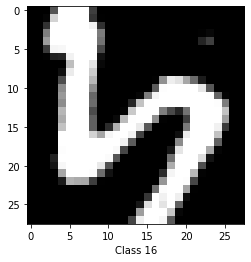

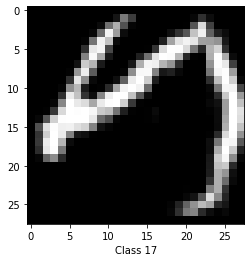

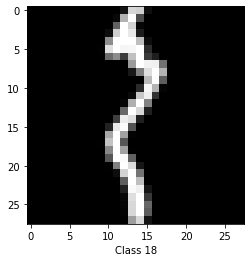

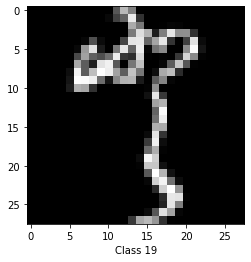

In [5]:
for i in range(20):
    plt.figure()
    plt.xlabel('Class ' + str(i))
    plt.imshow(np.reshape(train_images[np.where(train_labels == i)[0][100]], (28, 28)), cmap='gray')

<div dir="rtl">
    <font size="3">• رسم نمودار میله ای فراوانی داده های هر کلاس در مجموعه داده های test و train</font>
</div>

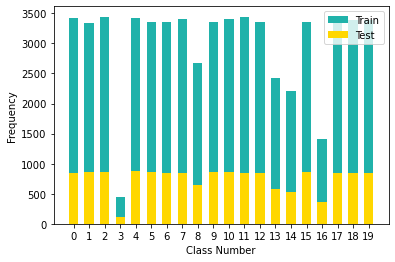

In [6]:
x = [int(i) for i in range(20)]

y_train_labels = [0]*20
y_test_labels = [0]*20

for label in list(train_labels):
    y_train_labels[label[0].astype(np.uint8)] += 1
    
for label in test_labels:
    y_test_labels[label[0].astype(np.uint8)] += 1

fig, ax = plt.subplots()
ax.bar(x, y_train_labels, 0.6, label='Train', color='lightseagreen')
ax.bar(x, y_test_labels, 0.6, label='Test', color='gold')
ax.set_ylabel('Frequency')
ax.set_xlabel('Class Number')
ax.set_xticks(x)
ax.legend()
plt.show()

<div dir="rtl">
    <font size="3"><br>• نرمال کردن داده های test و train</font>
    <font size="3"><br>داده ها را نرمالایز می کنیم تا از سرریز کردن یا کوچک شدن بیش از اندازه گرادیان (NaN) جلوگیری کنیم. همچنین این کار موجب می شود داده ها دارای scale مشترک شوند (داده هایی با چندین ویژگی عددی متفاوت)</font>
</div>

In [7]:
train_images = train_images / 255
test_images = test_images / 255

<div dir="rtl">
    <font size="4"><b>فاز دوم: تکمیل بخش های ناقص شبکه عصبی</b><br></font>
</div>

# Dataloader

In [8]:
class Dataloader:
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):

        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
        onehot_vectors = np.eye(n_classes)[labels.astype(np.uint8)]
        return onehot_vectors
    
    def __shuffle_dataset(self):
        randomize = np.arange(len(self.__data))
        np.random.shuffle(randomize)
        self.__data = self.__data[randomize]
        self.__onehot_labels = self.__onehot_labels[randomize]
    
    def __iter__(self):
        
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

# Activation Functions

In [9]:
class Identical:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)
    

class Relu:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        relu_value = np.matrix(np.maximum(matrix, 0), dtype=float)
        return relu_value

    def derivative(self, matrix):
        relu_derivative = np.matrix(np.vectorize(lambda x: 1 if x >= 0 else 0)(matrix), dtype=float)
        return relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class LeakyRelu:
    
    def __init__(self, negative_slope=0.01):
        self.negative_slope = 0.01
    
    def __val(self, matrix):
        leacky_relu_value = np.matrix(np.vectorize(lambda x: x if x >= 0 else x * self.negative_slope)(matrix), dtype=float)
        return leacky_relu_value

    def derivative(self, matrix):
        leacky_relu_derivative = np.matrix(np.vectorize(lambda x: 1 if x >= 0 else self.negative_slope)(matrix), dtype=float)
        return leacky_relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class Sigmoid:
    
    def __init__(self): pass

    def __val(self, matrix):
        sigmoid_value = np.matrix(np.vectorize(lambda x: 1 / (1 + np.exp(-x)))(matrix), dtype=float)
        return sigmoid_value

    def derivative(self, matrix):
        sigmoid_derivative = np.matrix(np.vectorize(lambda x: (1 / (1 + np.exp(-x))) * (1 - (1 / (1 + np.exp(-x)))))(matrix), dtype=float)
        return sigmoid_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)


class Softmax:
    
    def __init__(self): pass

    def __val(self, matrix):
        temp = np.matrix(matrix - np.max(matrix, axis=1), dtype=float)
        numerator = np.exp(temp)
        denominator = np.sum(numerator, axis=1)
        softmax_value = numerator / denominator
        return softmax_value
    
    def __call__(self, matrix):
        return self.__val(matrix)
    
class Tanh:
    
    def __init__(self): pass

    def __val(self, matrix):
        tanh_value = np.matrix(np.vectorize(lambda x: (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)))(matrix), dtype=float)
        return tanh_value

    def derivative(self, matrix):
        tanh_derivative = np.matrix(np.vectorize(lambda x: (1 - np.power((np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)), 2)))(matrix), dtype=float)
        return tanh_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

# Loss Function

In [10]:
class CrossEntropy: #(with softmax)
    
    def __init__(self): pass

    def __val(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        temp = np.matrix(true_val - np.max(true_val, axis=1), dtype=float)
        numerator = np.exp(temp)
        denominator = np.sum(numerator, axis=1)  
        softmax_value = numerator / denominator
        softmax_value = np.clip(softmax_value, 1e-12, 1. - 1e-12)
        N = softmax_value.shape[0]
        cross_entropy_value = -np.sum(np.multiply(np.matrix(expected_val, dtype=float), np.log(softmax_value + 1e-9))) / N
        return cross_entropy_value
        
    def derivative(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        temp = np.matrix(true_val - np.max(true_val, axis=1), dtype=float)
        numerator = np.exp(temp)
        denominator = np.sum(numerator, axis=1)
        softmax_value = numerator / denominator
        cross_entropy_derivative = softmax_value - np.matrix(expected_val, dtype=float)
        return cross_entropy_derivative
    
    def __call__(self, true_val, expected_val):
        return self.__val(true_val, expected_val)

<div dir="rtl">
    <font size="3"><br>
برای آپدیت وزن ها از رابطه مطرح شده در کلاس و جلسه توجیهی استفاده می شود. برای آپدیت بایاس کافی است فرض کنیم هر داده ی ورودی یک ویژگی با مقدار همواره 1 دارد. در این صورت می توان آپدیت بایاس را مشابه آپدیت وزن ها در نظر گرفت.</font>
</div>

# Layer

In [11]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.
  
    def __init__(self, input_size, output_size, 
                 activation=Identical(), initial_weight='uniform', **initializing_parameters):
        
        assert type(initial_weight)==str, 'Undefined activation function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'


        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1)
        self.__last_input = np.matrix(layer_input, dtype=float)
        self.__last_activation_input = self.__last_input * self.__weight + self.__bias
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_input)
        self.__last_activation_output = self.__activation(self.__last_activation_input)
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        backprop_tensor = np.matrix(backprop_tensor, dtype=float)
        delta_weight = np.matrix.transpose(self.__last_input) * np.multiply(backprop_tensor, self.__last_activation_derivative)
        temp = np.matrix(np.ones((np.size(backprop_tensor, 0), 1)), dtype=float)
        delta_bias = np.matrix.transpose(temp) * np.multiply(backprop_tensor, self.__last_activation_derivative)
        backprop_tensor = np.multiply(backprop_tensor, self.__last_activation_derivative) * np.matrix.transpose(self.__weight)
        self.__bias = self.__bias - (lr * delta_bias)
        self.__weight = self.__weight - (lr * delta_weight)
        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        weights = np.matrix(np.random.uniform(low, high, (dim1, dim2)), dtype=float)
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        weights = np.matrix(np.random.normal(mean, np.sqrt(var), (dim1, dim2)), dtype=float)
        return weights
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

# Feed Forward Neural Network

In [12]:
class FeedForwardNN:
    
    def __init__(self, input_shape):
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    
    def forward(self, network_input):
        assert type(self.__output_shape) != None, "Model is not compiled!"
        network_output = network_input
        for i in range(len(self.__layers_list)):
            network_output = self.__layers_list[i].forward(network_output)
        return network_output
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            
            if print_results: 
                print('Epoch {}:'.format(epoch)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
                    
        return log
    
    
    def __train(self, trainloader):
        bach_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        bach_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):
        output = self.forward(x_batch)
        batch_accuracy = self.__compute_accuracy(output, y_batch)
        batch_average_loss = self.__loss(output, y_batch)
        self.__update_weights(output, y_batch)
        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):
        output = self.forward(x_batch)
        batch_accuracy = self.__compute_accuracy(output, y_batch)
        batch_average_loss = self.__loss(output, y_batch)
        return (batch_accuracy, batch_average_loss)
            
        
    def __get_labels(self, outputs):
        labels = outputs.argmax(axis=1)
        return labels
    
    
    def __compute_accuracy(self, output, expected_output):
        labels = self.__get_labels(output)
        expected_labels = self.__get_labels(expected_output)
        temp = labels - expected_labels
        accuracy = np.matrix(np.vectorize(lambda x: 1 if x == 0 else 0)(temp), dtype=float)
        return np.mean(accuracy)
    
    
    def __update_weights(self, output, y_train):
        backprop_tensor = self.__loss.derivative(output, y_train)
        for i in range(len(self.__layers_list) - 1, -1, -1):
            backprop_tensor = self.__layers_list[i].update_weights(backprop_tensor, self.__lr)
        return

<div dir="rtl">
    <font size="4"><b>فاز سوم: طبقه بندی داده ها</b><br></font>
    <font size="3">قسمت اول) آموزش شبکه</font>
</div>

In [13]:
train_images_copy = np.copy(train_images)
train_labels_copy = np.copy(train_labels)
test_images_copy = np.copy(test_images)
test_labels_copy = np.copy(test_labels)
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 20
TRAINLOADER = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=64, shuffle=True)
TESTLOADER = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=64, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(25, activation=Relu(), weight_initializer='uniform')
network.add_layer(20, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.5736107409381663	Average Loss: 1.4958321771729495
	Test: Average Accuracy: 0.6279920212765957	Average Loss: 1.3393484512370448
Epoch 2:
	Train: Average Accuracy: 0.7574960021321961	Average Loss: 0.8779632502308076
	Test: Average Accuracy: 0.6701462765957447	Average Loss: 1.18758050893573
Epoch 3:
	Train: Average Accuracy: 0.7874966684434968	Average Loss: 0.7735052060734968
	Test: Average Accuracy: 0.692220744680851	Average Loss: 1.1204180628852112
Epoch 4:
	Train: Average Accuracy: 0.8081856343283582	Average Loss: 0.7047694909075279
	Test: Average Accuracy: 0.7013297872340426	Average Loss: 1.0727409853530776
Epoch 5:
	Train: Average Accuracy: 0.8212120202558635	Average Loss: 0.6555004586686772
	Test: Average Accuracy: 0.7191932624113476	Average Loss: 1.021924465685062
Epoch 6:
	Train: Average Accuracy: 0.8302738539445629	Average Loss: 0.6204718919290603
	Test: Average Accuracy: 0.7247118794326242	Average Loss: 0.9937265812626727
Epoch 7:
	Train: Ave

<div dir="rtl">
    <font size="3">قسمت دوم) وزن دهی شبکه<br>
    درصورت صفر قرار دادن وزنها، مقدار Average Loss حدودا 2.9 باقی میماند و Average Accuracy نیز مقادیر 0.056 تا 0.057 خواهد داشت.</font>
</div>

<div dir="rtl">
    <font size="3">قسمت سوم) تاثیر learning rate<br>
    افزایش بیش از حد این متغییر ممکن است باعث سرریز شدن گرادیان و نرسیدن به global minimum شود. کاهش بیش از حد آن نیز میتواند باعث کند شدن فرآیند آموزش (دیرتر رسیدن به global minimum) شود.</font>
</div>

<div dir="rtl">
    <font size="3">ده برابر کردن learning rate:</font>
</div>

In [14]:
train_images_copy = np.copy(train_images)
train_labels_copy = np.copy(train_labels)
test_images_copy = np.copy(test_images)
test_labels_copy = np.copy(test_labels)
INPUT_SHAPE = 784
LEARNING_RATE = 0.01
EPOCHS = 20
TRAINLOADER = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=64, shuffle=True)
TESTLOADER = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=64, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(25, activation=Relu(), weight_initializer='uniform')
network.add_layer(20, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.650503065031983	Average Loss: 1.2212737547963906
	Test: Average Accuracy: 0.6747340425531915	Average Loss: 1.1818289777102553
Epoch 2:
	Train: Average Accuracy: 0.7878631396588486	Average Loss: 0.7619290908230654
	Test: Average Accuracy: 0.6915558510638298	Average Loss: 1.118109212309809
Epoch 3:
	Train: Average Accuracy: 0.8094682835820896	Average Loss: 0.6828472935978468
	Test: Average Accuracy: 0.7152925531914893	Average Loss: 1.0344536097316779
Epoch 4:
	Train: Average Accuracy: 0.8201292643923241	Average Loss: 0.6363432251574576
	Test: Average Accuracy: 0.7159131205673758	Average Loss: 1.033330313211319
Epoch 5:
	Train: Average Accuracy: 0.8292410714285714	Average Loss: 0.6014419043212993
	Test: Average Accuracy: 0.7096852836879434	Average Loss: 1.0817878396061662
Epoch 6:
	Train: Average Accuracy: 0.8350379797441365	Average Loss: 0.5775354332017548
	Test: Average Accuracy: 0.7304964539007093	Average Loss: 1.0183631363971697
Epoch 7:
	Train: Av

<div dir="rtl">
    <font size="3">0.1 برابر کردن learning rate:</font>
</div>

In [15]:
train_images_copy = np.copy(train_images)
train_labels_copy = np.copy(train_labels)
test_images_copy = np.copy(test_images)
test_labels_copy = np.copy(test_labels)
INPUT_SHAPE = 784
LEARNING_RATE = 0.0001
EPOCHS = 20
TRAINLOADER = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=64, shuffle=True)
TESTLOADER = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=64, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(25, activation=Relu(), weight_initializer='uniform')
network.add_layer(20, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.11280650319829424	Average Loss: 2.8443478721380435
	Test: Average Accuracy: 0.2646276595744681	Average Loss: 2.640520644179756
Epoch 2:
	Train: Average Accuracy: 0.410214552238806	Average Loss: 2.242592974599475
	Test: Average Accuracy: 0.43707890070921984	Average Loss: 2.0837831175143076
Epoch 3:
	Train: Average Accuracy: 0.5828724680170576	Average Loss: 1.609266847264576
	Test: Average Accuracy: 0.5071586879432624	Average Loss: 1.7242933722816869
Epoch 4:
	Train: Average Accuracy: 0.6436067430703625	Average Loss: 1.302202508397809
	Test: Average Accuracy: 0.5465868794326242	Average Loss: 1.5654457159371997
Epoch 5:
	Train: Average Accuracy: 0.6764892057569296	Average Loss: 1.1681639298024922
	Test: Average Accuracy: 0.5695921985815604	Average Loss: 1.4926323148796465
Epoch 6:
	Train: Average Accuracy: 0.6957289445628998	Average Loss: 1.0923193971750806
	Test: Average Accuracy: 0.5858377659574469	Average Loss: 1.4386229349619841
Epoch 7:
	Train: Av

<div dir="rtl">
    <font size="3">قسمت چهارم) تاثیر activation function <br>
    از آنجایی که در توابع Sigmoid و Tanh محاسبات exp وجود دارد این توابع کندتر هستند. همچنین در تابع sigmoid ممکن است که گرادیان صفر شود <br>
    تابع LeakyRelu از آن جهت نسبت به relu برتری دارد که در این تابع مقادیر منفی نادیده گرفته نمیشوند و هیچ از یک از ویژگی ها از دست نمیرود.</font>
</div>

<div dir="rtl">
    <font size="3">تابع فعالساز LeakyRelu</font>
</div>

In [16]:
train_images_copy = np.copy(train_images)
train_labels_copy = np.copy(train_labels)
test_images_copy = np.copy(test_images)
test_labels_copy = np.copy(test_labels)
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 20
TRAINLOADER = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=64, shuffle=True)
TESTLOADER = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=64, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(25, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(20, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.5724280383795309	Average Loss: 1.5118650069222073
	Test: Average Accuracy: 0.629011524822695	Average Loss: 1.3381930988947328
Epoch 2:
	Train: Average Accuracy: 0.7585787579957356	Average Loss: 0.8737590995912614
	Test: Average Accuracy: 0.6810062056737588	Average Loss: 1.1655652420256328
Epoch 3:
	Train: Average Accuracy: 0.7918776652452025	Average Loss: 0.7621461334692845
	Test: Average Accuracy: 0.695811170212766	Average Loss: 1.1116932465035623
Epoch 4:
	Train: Average Accuracy: 0.8102678571428571	Average Loss: 0.6967536139678306
	Test: Average Accuracy: 0.7156914893617021	Average Loss: 1.0375330171935384
Epoch 5:
	Train: Average Accuracy: 0.822311433901919	Average Loss: 0.6460135944689614
	Test: Average Accuracy: 0.723470744680851	Average Loss: 1.0128316564933206
Epoch 6:
	Train: Average Accuracy: 0.8326392590618337	Average Loss: 0.6094954891190868
	Test: Average Accuracy: 0.7343085106382978	Average Loss: 0.9755247961027221
Epoch 7:
	Train: Ave

<div dir="rtl">
    <font size="3">تابع فعالساز sigmoid</font>
</div>

In [17]:
train_images_copy = np.copy(train_images)
train_labels_copy = np.copy(train_labels)
test_images_copy = np.copy(test_images)
test_labels_copy = np.copy(test_labels)
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 20
TRAINLOADER = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=64, shuffle=True)
TESTLOADER = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=64, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(25, activation=Sigmoid(), weight_initializer='uniform')
network.add_layer(20, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.0630830223880597	Average Loss: 2.9494130462006845
	Test: Average Accuracy: 0.1257535460992908	Average Loss: 2.928286426448388
Epoch 2:
	Train: Average Accuracy: 0.18799973347547974	Average Loss: 2.70205672011154
	Test: Average Accuracy: 0.2522828014184397	Average Loss: 2.5151788717859778
Epoch 3:
	Train: Average Accuracy: 0.3809801439232409	Average Loss: 2.181041746106267
	Test: Average Accuracy: 0.3970744680851064	Average Loss: 2.1017616446879392
Epoch 4:
	Train: Average Accuracy: 0.5610840884861408	Average Loss: 1.6970558519719947
	Test: Average Accuracy: 0.4978723404255319	Average Loss: 1.775044240069973
Epoch 5:
	Train: Average Accuracy: 0.6452558635394456	Average Loss: 1.3634377744885786
	Test: Average Accuracy: 0.5559840425531914	Average Loss: 1.564718032399717
Epoch 6:
	Train: Average Accuracy: 0.6928304904051172	Average Loss: 1.1669039601754831
	Test: Average Accuracy: 0.591688829787234	Average Loss: 1.4500064270518747
Epoch 7:
	Train: Avera

<div dir="rtl">
    <font size="3">تابع فعالساز Tanh</font>
</div>

In [18]:
train_images_copy = np.copy(train_images)
train_labels_copy = np.copy(train_labels)
test_images_copy = np.copy(test_images)
test_labels_copy = np.copy(test_labels)
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 20
TRAINLOADER = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=64, shuffle=True)
TESTLOADER = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=64, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(25, activation=Tanh(), weight_initializer='uniform')
network.add_layer(20, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.11780383795309168	Average Loss: 2.791496960386238
	Test: Average Accuracy: 0.20152925531914895	Average Loss: 2.4681142321140097
Epoch 2:
	Train: Average Accuracy: 0.3971381929637527	Average Loss: 1.9725915673884493
	Test: Average Accuracy: 0.46170212765957447	Average Loss: 1.856076894582825
Epoch 3:
	Train: Average Accuracy: 0.6088419509594882	Average Loss: 1.410070532410511
	Test: Average Accuracy: 0.5269281914893617	Average Loss: 1.6271555930386523
Epoch 4:
	Train: Average Accuracy: 0.6550839552238806	Average Loss: 1.205329540334429
	Test: Average Accuracy: 0.5579122340425532	Average Loss: 1.5150101753368348
Epoch 5:
	Train: Average Accuracy: 0.6825026652452025	Average Loss: 1.1076996866277953
	Test: Average Accuracy: 0.5724955673758865	Average Loss: 1.4838836411882559
Epoch 6:
	Train: Average Accuracy: 0.7014092484008528	Average Loss: 1.044794670011257
	Test: Average Accuracy: 0.5863475177304965	Average Loss: 1.4137287217670949
Epoch 7:
	Train: A

<div dir="rtl">
    <font size="3">قسمت پنجم) تاثیر batch size<br>
    استفاده از Batch Size موجب می شود که شبکه در هر ایپاک، به جای مشاهده ی کامل تمامی داده ها و آپدیت وزن ها، داده ها را به صورت دسته ای مشاهده کند و پس از مشاهده ی هر دسته وزن ها را آپدیت کند.<br>
        هرچه Batch Size بزرگتر شود، مدت زمان هر ایپاک کمتر خواهد شد و در تعداد ایپاک های بیشتری به مدل مطلوب خواهیم رسید
    در عوض هرچه Batch Size کوچکتر شود، مدت زمان هر ایپاک بیشتر خواهد شد و از طرف دیگر در تعداد ایپاک های کمتری به مدل مطلوب خواهیم رسید.<br>
    <br>
    استفاده از Batch Size های خیلی کوچک از یک طرف زمان هر ایپاک را بطور چشمگیری افزایش میدهد و از طرف دیگر آموزش مدل را مختل می کند. زیرا شبکه در هر Batch، داده های کاملا جدیدی خواهد دید و وزن های خود را با توجه به آن Batch بسیار تغییر خواهد داد  و در Batch های بعدی نیز این روند معیوب ادامه خواهد یافت. علت این اتفاق این است که مقدار Batch Size باید به گونه ای باشد که داده های هر Batch، نماینده ی نسبتا مناسبی از تمامی داده ها باشند.</font>
</div>

<div dir="rtl">
    <font size="3">batch size = 16</font>
</div>

In [19]:
train_images_copy = np.copy(train_images)
train_labels_copy = np.copy(train_labels)
test_images_copy = np.copy(test_images)
test_labels_copy = np.copy(test_labels)
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 20
TRAINLOADER = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=16, shuffle=True)
TESTLOADER = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=16, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(25, activation=Relu(), weight_initializer='uniform')
network.add_layer(20, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.5774	Average Loss: 1.478086056035647
	Test: Average Accuracy: 0.6196028784648188	Average Loss: 1.3468485458773836
Epoch 2:
	Train: Average Accuracy: 0.7577833333333334	Average Loss: 0.8756342544998487
	Test: Average Accuracy: 0.6735740938166311	Average Loss: 1.1657426909799264
Epoch 3:
	Train: Average Accuracy: 0.7926833333333333	Average Loss: 0.7545213002639105
	Test: Average Accuracy: 0.6937633262260128	Average Loss: 1.0864664868771394
Epoch 4:
	Train: Average Accuracy: 0.8130166666666667	Average Loss: 0.6839240397277058
	Test: Average Accuracy: 0.7123534115138592	Average Loss: 1.0419442042075628
Epoch 5:
	Train: Average Accuracy: 0.825	Average Loss: 0.6348080546808195
	Test: Average Accuracy: 0.7250799573560768	Average Loss: 1.001883128280427
Epoch 6:
	Train: Average Accuracy: 0.8350833333333333	Average Loss: 0.6000534806332675
	Test: Average Accuracy: 0.7308768656716418	Average Loss: 0.9762610533177432
Epoch 7:
	Train: Average Accuracy: 0.840066

<div dir="rtl">
    <font size="3">batch size = 32</font>
</div>

In [20]:
train_images_copy = np.copy(train_images)
train_labels_copy = np.copy(train_labels)
test_images_copy = np.copy(test_images)
test_labels_copy = np.copy(test_labels)
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 20
TRAINLOADER = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=32, shuffle=True)
TESTLOADER = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=32, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(25, activation=Relu(), weight_initializer='uniform')
network.add_layer(20, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.57525	Average Loss: 1.486992963891531
	Test: Average Accuracy: 0.6271544065387349	Average Loss: 1.3358066253704377
Epoch 2:
	Train: Average Accuracy: 0.7573833333333333	Average Loss: 0.8788831809109537
	Test: Average Accuracy: 0.6740183013503909	Average Loss: 1.1785853973265328
Epoch 3:
	Train: Average Accuracy: 0.7890666666666667	Average Loss: 0.7693655931658036
	Test: Average Accuracy: 0.6892546197583511	Average Loss: 1.1148386892096471
Epoch 4:
	Train: Average Accuracy: 0.8057666666666666	Average Loss: 0.7045261369801439
	Test: Average Accuracy: 0.7059790334044066	Average Loss: 1.0797247522277862
Epoch 5:
	Train: Average Accuracy: 0.81785	Average Loss: 0.6590262959501771
	Test: Average Accuracy: 0.7132418265813789	Average Loss: 1.0313063556679214
Epoch 6:
	Train: Average Accuracy: 0.8274666666666667	Average Loss: 0.6244723963190828
	Test: Average Accuracy: 0.7255463752665245	Average Loss: 1.0120430059691419
Epoch 7:
	Train: Average Accuracy: 0.83

<div dir="rtl">
    <font size="3">batch size = 256</font>
</div>

In [21]:
train_images_copy = np.copy(train_images)
train_labels_copy = np.copy(train_labels)
test_images_copy = np.copy(test_images)
test_labels_copy = np.copy(test_labels)
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 20
TRAINLOADER = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=256, shuffle=True)
TESTLOADER = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=256, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(25, activation=Relu(), weight_initializer='uniform')
network.add_layer(20, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.49384973404255317	Average Loss: 1.8229590190049487
	Test: Average Accuracy: 0.6066360950044603	Average Loss: 1.3672815496557313
Epoch 2:
	Train: Average Accuracy: 0.757064494680851	Average Loss: 0.8707260954332507
	Test: Average Accuracy: 0.6892248829170383	Average Loss: 1.1263119285313945
Epoch 3:
	Train: Average Accuracy: 0.8010195035460992	Average Loss: 0.722496632955831
	Test: Average Accuracy: 0.7133000669045495	Average Loss: 1.0382246461215474
Epoch 4:
	Train: Average Accuracy: 0.8205729166666668	Average Loss: 0.6501488448840927
	Test: Average Accuracy: 0.726823845896521	Average Loss: 0.9981307514568484
Epoch 5:
	Train: Average Accuracy: 0.832563164893617	Average Loss: 0.608398994190478
	Test: Average Accuracy: 0.7315245874219447	Average Loss: 0.9656183566564981
Epoch 6:
	Train: Average Accuracy: 0.8400875443262412	Average Loss: 0.5766864506912484
	Test: Average Accuracy: 0.7406089707850133	Average Loss: 0.9382954366826609
Epoch 7:
	Train: Ave

<div dir="rtl">
    <font size="3">قسمت ششم) تاثیر epoch<br>
        دلیل استفاده از چندین ایپاک، بهبود عملکرد شبکه است زیرا شبکه در هر ایپاک وزنهای خود به مقادیری بهتری آپدیت میکند.<br>
        افزایش بی رویه تعداد ایپاک ها میتواند باعث overfitting (یادگیری بیش از حد از داده های آموزش) شود و به این ترتیب شبکه برخلاف عملکرد مناسب برروی داده های آموزش، برروی داده های تست بخوبی کار نخواهد کرد.
    </font>
</div>

In [22]:
train_images_copy = np.copy(train_images)
train_labels_copy = np.copy(train_labels)
test_images_copy = np.copy(test_images)
test_labels_copy = np.copy(test_labels)
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 200
TRAINLOADER = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=64, shuffle=True)
TESTLOADER = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=64, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(25, activation=Relu(), weight_initializer='uniform')
network.add_layer(20, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.5718616737739872	Average Loss: 1.4952867784641262
	Test: Average Accuracy: 0.6325132978723405	Average Loss: 1.3131795365732466
Epoch 2:
	Train: Average Accuracy: 0.7618103678038379	Average Loss: 0.8647276499455293
	Test: Average Accuracy: 0.676174645390071	Average Loss: 1.1716746001697151
Epoch 3:
	Train: Average Accuracy: 0.7935601012793176	Average Loss: 0.7574536937495051
	Test: Average Accuracy: 0.695700354609929	Average Loss: 1.0975007046638656
Epoch 4:
	Train: Average Accuracy: 0.8108675373134329	Average Loss: 0.6914256498723333
	Test: Average Accuracy: 0.7128102836879433	Average Loss: 1.0447332713696689
Epoch 5:
	Train: Average Accuracy: 0.8248767324093816	Average Loss: 0.6427844525343076
	Test: Average Accuracy: 0.7259530141843971	Average Loss: 1.0067818531303598
Epoch 6:
	Train: Average Accuracy: 0.8344549573560768	Average Loss: 0.6070895063798237
	Test: Average Accuracy: 0.7357269503546099	Average Loss: 0.973438097301563
Epoch 7:
	Train: Av

	Train: Average Accuracy: 0.8950059968017058	Average Loss: 0.3681845520979749
	Test: Average Accuracy: 0.7578457446808511	Average Loss: 0.9550809573339373
Epoch 52:
	Train: Average Accuracy: 0.8958722014925373	Average Loss: 0.3665210241388292
	Test: Average Accuracy: 0.7648271276595745	Average Loss: 0.9444844547571339
Epoch 53:
	Train: Average Accuracy: 0.8966384594882729	Average Loss: 0.3650003738537668
	Test: Average Accuracy: 0.7578900709219859	Average Loss: 0.9612689233309062
Epoch 54:
	Train: Average Accuracy: 0.8953391524520256	Average Loss: 0.3625101403403823
	Test: Average Accuracy: 0.758732269503546	Average Loss: 0.9699432624758157
Epoch 55:
	Train: Average Accuracy: 0.8960054637526652	Average Loss: 0.3620209967893558
	Test: Average Accuracy: 0.7617021276595745	Average Loss: 0.9593065485938808
Epoch 56:
	Train: Average Accuracy: 0.8966884328358209	Average Loss: 0.3617050474350293
	Test: Average Accuracy: 0.7631870567375886	Average Loss: 0.9502976802164692
Epoch 57:
	Train: Ave

	Train: Average Accuracy: 0.9054337686567164	Average Loss: 0.3263251551259655
	Test: Average Accuracy: 0.7537455673758865	Average Loss: 1.0362884348604573
Epoch 102:
	Train: Average Accuracy: 0.9046175373134329	Average Loss: 0.3267005485721407
	Test: Average Accuracy: 0.7572251773049646	Average Loss: 1.0309837631400862
Epoch 103:
	Train: Average Accuracy: 0.9072661247334755	Average Loss: 0.3242558042503786
	Test: Average Accuracy: 0.7556294326241135	Average Loss: 1.0385987005951933
Epoch 104:
	Train: Average Accuracy: 0.9051172707889126	Average Loss: 0.3247615201662189
	Test: Average Accuracy: 0.7597517730496455	Average Loss: 1.0317349699569947
Epoch 105:
	Train: Average Accuracy: 0.9064998667377399	Average Loss: 0.3238942915992181
	Test: Average Accuracy: 0.7544547872340426	Average Loss: 1.046446943869011
Epoch 106:
	Train: Average Accuracy: 0.9063499466950959	Average Loss: 0.3226295321861662
	Test: Average Accuracy: 0.754609929078014	Average Loss: 1.0582523683628193
Epoch 107:
	Train

	Test: Average Accuracy: 0.7513519503546099	Average Loss: 1.1202978660732845
Epoch 151:
	Train: Average Accuracy: 0.9116138059701493	Average Loss: 0.3030148191708543
	Test: Average Accuracy: 0.7532358156028369	Average Loss: 1.116247307601026
Epoch 152:
	Train: Average Accuracy: 0.9112473347547975	Average Loss: 0.3041587581597565
	Test: Average Accuracy: 0.7497340425531915	Average Loss: 1.1245495544119906
Epoch 153:
	Train: Average Accuracy: 0.9106643123667377	Average Loss: 0.3041750098289812
	Test: Average Accuracy: 0.7539671985815604	Average Loss: 1.1074448187667099
Epoch 154:
	Train: Average Accuracy: 0.9104977345415778	Average Loss: 0.3031090958086497
	Test: Average Accuracy: 0.7479831560283688	Average Loss: 1.1306645435766542
Epoch 155:
	Train: Average Accuracy: 0.9109141791044776	Average Loss: 0.3026940667444093
	Test: Average Accuracy: 0.7522606382978724	Average Loss: 1.1172819534066993
Epoch 156:
	Train: Average Accuracy: 0.9111473880597015	Average Loss: 0.3024026426585769
	Test

	Train: Average Accuracy: 0.9137959754797441	Average Loss: 0.2907835611359167
	Test: Average Accuracy: 0.7488031914893617	Average Loss: 1.1926905160657024


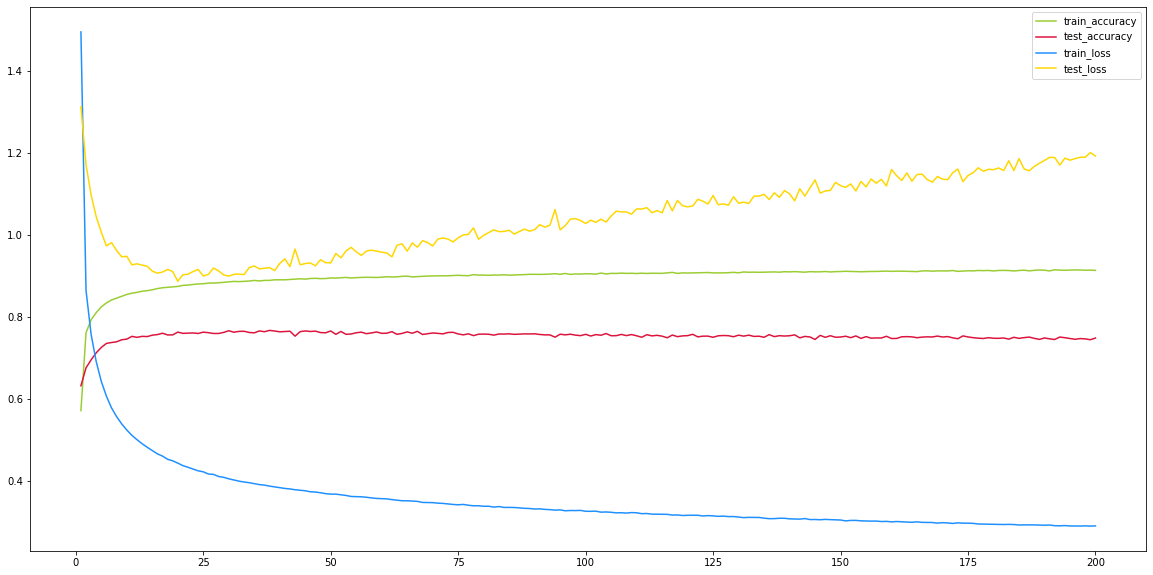

In [23]:
epochs = range(1, 201)
plt.plot(epochs, log['train_accuracy'], color='yellowgreen', label='train_accuracy')
plt.plot(epochs, log['test_accuracy'], color='crimson', label='test_accuracy')
plt.plot(epochs, log['train_loss'], color='dodgerblue', label='train_loss')
plt.plot(epochs, log['test_loss'], color='gold', label='test_loss')
plt.gcf().set_size_inches((20, 10))
plt.legend();

<div dir="rtl">
    <font size="3">همانطور که مشاهده میشود که از یک مرحله به بعد loss در داده های تست روند صعودی پیدا میکند در حالیکه در داده های آموزش همان روند نزولی قبل (با شدت کمتر) را دارد.</font>
</div>